Imports

In [19]:
import copy
from typing import List, Dict
import random
import inspyred
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Clases

In [20]:
class Piece:
    def __init__(self, x_dim: int, y_dim: int):
        self.x_dim = x_dim
        self.y_dim = y_dim

    def generate_random_pieces(cardinality, max_size) -> list:
        pieces = []
        for i in range(cardinality):
            pieces.append(Piece(random.randint(0, max_size),random.randint(0, max_size)))
        return pieces

In [21]:
class Choice:
    def __init__(self, piece: Piece, x_pos: int, y_pos: int):
        self.piece = piece
        self.x_pos = x_pos
        self.y_pos = y_pos

In [22]:
class Solution:
    def __init__(self, x_dim: int, y_dim: int):
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.board = [[False for column in range(x_dim)] for row in range(y_dim)]
        self.used_pieces = [False for row in range(Num_Pieces)]
        self.pieces_order = [0 for row in range(Num_Pieces)]

    def does_Choice_fit(self, choice: Choice) -> bool:
        if choice.piece.x_dim + choice.x_pos > self.x_dim:
            return False
        if choice.piece.y_dim + choice.y_pos > self.y_dim:
            return False
        for i in range(choice.piece.x_dim):
            for j in range(choice.piece.y_dim):
                if self.board[choice.x_pos + i][choice.y_pos + j]:
                    return False
        return True
    
    def get_Choice (self, piece: Piece) -> Choice:
        for i in range(self.x_dim):  # Recorre todas las posiciones del espacio
            for j in range(self.y_dim):
                posible = Choice(piece, i, j)
                if self.does_Choice_fit(posible):
                    return Choice(piece, i, j)
        return Choice(piece, -1, -1)
                
    def place_Choice(self, choice: Choice, order: int):
        for i in range(choice.piece.x_dim):
            for j in range(choice.piece.y_dim):
                self.board[choice.x_pos + i][choice.y_pos + j] = True
        self.used_pieces[Pieces.index(choice.piece)] = True
        self.pieces_order[Pieces.index(choice.piece)] = order

    def does_use_piece(self, piece: Piece):
        return self.used_pieces[Pieces.index(piece)]
    
    def get_piece_order(self, piece: Piece):
        return self.pieces_order[Pieces.index(piece)]
    
    def huecos (self) -> list:
        board_copy = copy.deepcopy(self.board)
        array = []
        for i in range(self.x_dim):
            for j in range(self.y_dim):
                if board_copy[i][j] == 0:
                    board_copy[i][j] = 1
                    array.append(explore_adyacent(board_copy, i, j))
        return array

    def evaluate_fitness(self) -> float: 
        espacios = self.huecos()
        value = 100
        value = value - len(espacios) * 5 #penalizar numero de huecos
        for hueco in espacios:
            value = value - (1/hueco) * 3
        return clamp(value)

In [23]:
class Pheromone:
    def __init__(self):
        self.placed = 0.5 #considero si esta colocado o no como una feromona
        self.placeOrder = [0.5 for i in range(Num_Pieces)] #cada posicion indica el orden en el que se coloca la pieza

Constantes

In [24]:
numberOfIterations = 100
Board_side = 10
Num_Pieces = 20
Alpha  = 0.5
Beta   = 0.5
Pieces = Piece.generate_random_pieces(Num_Pieces, 4)
bestFitnessEvolution = []
mediaFitnessEvolution = []
pheromoneHistory = []

Utilidades

In [25]:
def clamp(value):
    if value > 0:
        return min(value, 1)
    else: 
        return max (value, 0)
    
def explore_adyacent(temp, x, y): #hay que marcar la celda inicial antes de llamarla
    area = 0
    # Verificar si la celda adyacente está dentro de los límites del espacio
    if x + 1 < len(temp) and temp[x+1][y] == 0:
        temp[x+1][y] = 1
        area += explore_adyacent(temp, x+1, y)
    if x - 1 >= 0 and temp[x-1][y] == 0:
        temp[x-1][y] = 1
        area += explore_adyacent(temp, x-1, y)
    if y + 1 < len(temp[0]) and temp[x][y+1] == 0:
        temp[x][y+1] = 1
        area += explore_adyacent(temp, x, y+1)
    if y - 1 >= 0 and temp[x][y-1] == 0:
        temp[x][y-1] = 1
        area += explore_adyacent(temp, x, y-1)
    if temp[x][y]:
        area += 1
    return area

Functions

In [26]:
def initialize_pheromones(): #creo un array donde cada pieza tiene una pos y un array de feromona
    Pheromones = [Pheromone() for i in range(Num_Pieces)]
    return Pheromones

In [27]:
def update_pheromones(Pheromones, Solution_list):
    New_Pheromones = Pheromones

    #Pheromones affected by evaporation
    for j in New_Pheromones:
        j.placed = (1 - 0.8) * j.placed
        for i in range(len(j.placeOrder)):
            j.placeOrder[i] = (1 - 0.8) * j.placeOrder[i]

    #Pheromones affected by pheromone amount
    #Fittnes of solution multiply by 0.7
    for tempSol in Solution_list:
        tempFit = tempSol.evaluate_fitness() * 0.7
        for tempPieza in range(len(Pieces)):
            if(tempSol.does_use_piece(Pieces[tempPieza])):
                New_Pheromones[tempPieza].placed = min(New_Pheromones[tempPieza].placed + tempFit, 1)
                tempPosition = tempSol.get_piece_order(Pieces[tempPieza])
                New_Pheromones[tempPieza].placeOrder[tempPosition] = min(New_Pheromones[tempPieza].placed + tempFit, 1)
            else:
                New_Pheromones[tempPieza].placed = max(New_Pheromones[tempPieza].placed - (tempFit * 0.6), 0)

    return New_Pheromones

In [28]:
def get_candidates(solution: Solution) -> list:
    Candidates = []
    for candidate in Pieces:
        if not solution.does_use_piece(candidate):
            choice = solution.get_Choice(candidate)
            if choice.x_pos != -1:
                Candidates.append(choice)               
    return Candidates

In [29]:
def heuristic(choice: Choice): #good place for experimentation
    size = choice.piece.x_dim * choice.piece.y_dim
    return size / (Board_side * Board_side)

In [30]:
def calculate_probabilities(Candidates: list, Pheromones: list, order: int):
    dividend = []
    sum = 0
    for i in range(0, len(Candidates)):
        dividend.append(pow((Pheromones[i].placed * Pheromones[i].placeOrder[order]),Alpha) * pow(heuristic(Candidates[i]),Beta))
        sum += dividend[i]

    if sum == 0:
        sum = 0.000001
    for j in dividend:
        j = j/sum
    return dividend

In [31]:
def random_choice(Candidates, Probabilities):
    for i in range(len(Candidates)):
        if random.random() < Probabilities[i]: #good option for experimenting an using other choosing algos
            return Candidates[i]
        return Candidates[len(Candidates)-1]

In [32]:
def construct_solution(Pheromones: list) -> Solution:
    solution = Solution(Board_side, Board_side)
    Candidates = get_candidates(solution) #candidates are always valid
    order = 0
    while (len(Candidates) > 0):
        Probabilities = calculate_probabilities(Candidates, Pheromones, order)
        choice = random_choice(Candidates, Probabilities)
        solution.place_Choice(choice, order)
        Candidates = get_candidates(solution)
        order = order + 1

    return solution

ACO

In [33]:
def ACO(n_ants):
    Pheromones = initialize_pheromones()
    mediaDeFitness = 0
    best_fitness = 0
    best_solution = []
    i = 0
    while (i < numberOfIterations):
        Solution_list = []
        for j in range(n_ants):
            solution = construct_solution(Pheromones)
            Solution_list.append(solution)
            fitness = solution.evaluate_fitness()
            mediaDeFitness = fitness + mediaDeFitness
            if (fitness > best_fitness):
                best_solution = solution
                best_fitness = fitness
        #guardo valores historicos para graficas
        bestFitnessEvolution.append(best_fitness)
        mediaFitnessEvolution.append(mediaDeFitness/n_ants)
        mediaDeFitness = 0
        for k in range(len(Pheromones)):
            pheromoneHistory.append(Pheromones[k].placeOrder)
        #----

        Pheromones = update_pheromones(Pheromones, Solution_list)

        i = i + 1 
    return best_solution

In [34]:
print(ACO(10))

Graficas

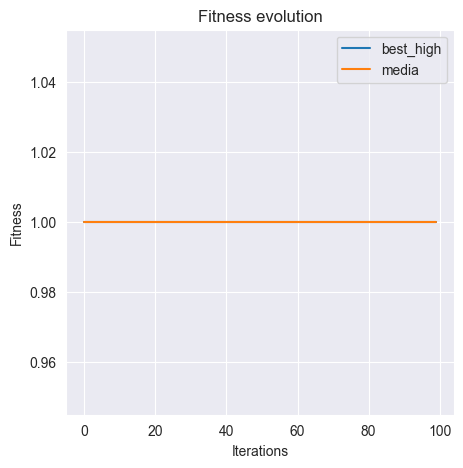

In [35]:
#Fitness evolution
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style('darkgrid')

best_fitness = np.array(bestFitnessEvolution)
media_fitness = np.array(mediaFitnessEvolution)

fig, axs = plt.subplots(figsize=(5,5))
axs.set_title('Fitness evolution')
axs.set_xlabel('Iterations')
axs.set_ylabel('Fitness')

axs.plot(best_fitness, label='best_high')
axs.plot(media_fitness, label='media')

plt.legend()

<Axes: >

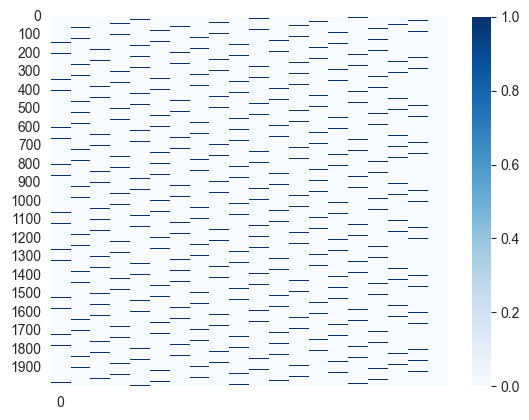

In [36]:
#Feromone evolution
pheromoneHistory = np.array(pheromoneHistory)
sns.heatmap(pheromoneHistory, cmap='Blues', xticklabels=100, yticklabels=100)